# Dataset

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

from lifelines.datasets import load_rossi
from sksurv.metrics import concordance_index_censored

from utils.model import Model 

data = load_rossi()
data.dropna(inplace=True)
print(data.shape)
data.head()

2025-05-04 17:48:20.669752: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(432, 9)


,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


In [2]:
event_col = "arrest"
duration_col = "week"

X = data.drop(columns=[event_col, duration_col])
X.shape

(432, 7)

# Train-test split 

In [3]:
from utils.data import train_test_splitting

train_idx, test_idx = train_test_splitting(
    np.arange(data.shape[0]), test_size=0.2, stratify=data[event_col].squeeze().astype(int)
)
# Data splits
data_train, data_test = data.iloc[train_idx], data.iloc[test_idx]
print(data_train.shape, data_test.shape)

(345, 9) (87, 9)


In [4]:
N_SPLITS = 2
DATA_SPLIT_IDX = np.array_split(np.arange(data_train.shape[0]), N_SPLITS)

In [5]:
duration_train = data_train[duration_col].to_numpy().squeeze()
duration_test = data_test[duration_col].to_numpy().squeeze()

event_train = data_train[event_col].to_numpy().squeeze()
event_test = data_test[event_col].to_numpy().squeeze()

In [6]:
from sksurv.util import Surv
# Create structured arrays
y_train = Surv.from_arrays(event=event_train, time=duration_train)
y_test = Surv.from_arrays(event=event_test, time=duration_test)
print(y_train.shape, y_test.shape)

(345,) (87,)


# Pre-processing

In [7]:
from utils.data import feature_scaling
# Scale features with Z-score transfrom 
X_train, X_test = feature_scaling(X.iloc[train_idx].values, X.iloc[test_idx].values)

In [8]:
from utils.data import init_knots
# Set knot locations 
knots = init_knots(duration_train, event_train, n_knots=5)
min(knots), max(knots)

(0.0, 3.9512437185814275)

# Initialize parameters

In [9]:
from utils.data import init_gamma, init_beta
from utils.splines import bspline_design_matrix

# Create one spline equation per time point 
D = bspline_design_matrix(np.log(duration_train), knots)

# Initialize gamma coefficients
gamma = init_gamma(D, duration_train)

# Initialize beta coefficients
beta = init_beta(X_train, y_train)

In [10]:
# Initialize global params
z_beta = np.zeros_like(beta)
z_gamma = np.zeros_like(gamma)

u_betas = [np.zeros_like(beta) for _ in range(N_SPLITS)]
u_gammas = [np.zeros_like(gamma) for _ in range(N_SPLITS)]

# Model fitting 

In [11]:
models = []
for _ in range(N_SPLITS):
    model_i = Model(epochs=1, knots=knots, learning_rate=0.01, l2_lambda=0)
    model_i.set_params({"beta": beta, "gamma": gamma})

    models.append(model_i)

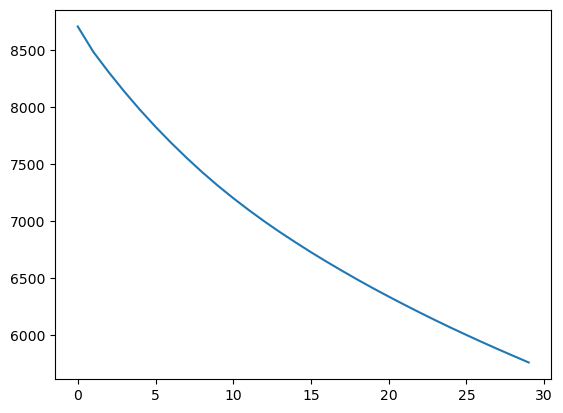

In [12]:
def server_update(beta_locals, gamma_locals, u_betas, u_gammas):
    
    beta_global = np.mean([b + u for b, u in zip(beta_locals, u_betas)], axis=0)
    gamma_global = np.mean([g + v for g, v in zip(gamma_locals, u_gammas)], axis=0)
    
    return beta_global, gamma_global


losses = []
for _ in range(30):

    beta_locals, gamma_locals, last_local_losses = [], [], [] 
    for i in range(N_SPLITS):

        X_train_i = feature_scaling(X.iloc[train_idx].values[DATA_SPLIT_IDX[i]])
        y_train_i = y_train[DATA_SPLIT_IDX[i]]

        # Fit local models 
        models[i].fit_fedadmm(
            X_train_i, y_train_i, z_beta, z_gamma, u_betas[i], u_gammas[i]
        )
        
        # Local update 
        beta_locals.append(models[i].beta)
        gamma_locals.append(models[i].gamma)

        # Dual variable update
        u_betas[i] = u_betas[i] + beta_locals[-1] - z_beta
        u_gammas[i] = u_gammas[i] + gamma_locals[-1] - z_gamma

        # Trace training loss 
        last_local_losses.append(models[i].losses[-1])

    losses.append(np.mean(last_local_losses))

    # Global update
    z_beta, z_gamma = server_update(beta_locals, gamma_locals, u_betas, u_gammas)

    
plt.figure()
plt.plot(losses)

# Global model

In [13]:
global_beta, global_gamma = server_update(beta_locals, gamma_locals, u_betas, u_gammas)

global_model = Model(epochs=0, knots=knots, learning_rate=0.01, l2_lambda=0)
global_model.set_params({"beta": global_beta, "gamma": global_gamma})

In [14]:
print(concordance_index_censored(event_train.astype(bool), duration_train, global_model.risk_score(X_train).squeeze()))
print(concordance_index_censored(event_test.astype(bool), duration_test, global_model.risk_score(X_test).squeeze()))

(0.642678117282813, 17421, 9679, 31, 1016)
(0.6166569936157864, 1062, 660, 1, 0)


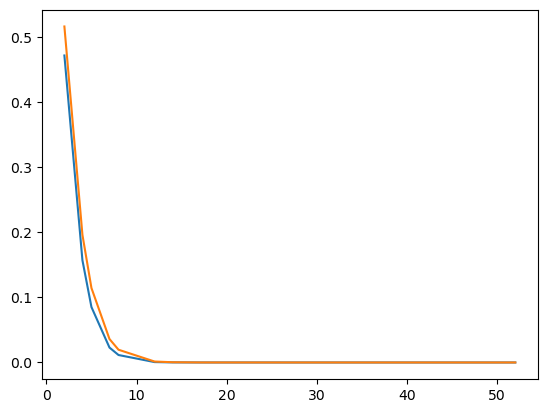

In [15]:
S0 = global_model.survival_curve(X_test[0], duration_test)
S1 = global_model.survival_curve(X_test[1], duration_test)

plt.figure()
idx = np.argsort(duration_test)
plt.plot(duration_test[idx], S0[idx, 0])
plt.plot(duration_test[idx], S1[idx, 0])

In [16]:
global_gamma

array([[-0.30999754,  0.65345937,  1.76419234,  3.01792574,  3.37154984,
         3.57789612,  3.64124393]])

In [17]:
global_beta

array([[-0.02110968, -0.02913223,  0.04522459, -0.03945724, -0.0362081 ,
        -0.01463654,  0.06266713]])